# Analysis Notebook for *Busecke and Abernathey, 2018*

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from surface_diffusivities import box_plot_dict, filter_1D, weighted_mean, \
    calculate_Kmix, xr_linregress, linear_trend, annual_range, xarray_norm

# For prettier output ignore all warnings
import warnings
warnings.filterwarnings('ignore')
    
%matplotlib inline

/Users/juliusbusecke/miniconda/envs/busecke_abernathey_2018/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/juliusbusecke/miniconda/envs/busecke_abernathey_2018/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/juliusbusecke/miniconda/envs/busecke_abernathey_2018/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/juliusbusecke/miniconda/envs/busecke_abernathey_2018/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/juliusbusecke/miniconda/envs/busecke_abernathey_2018/lib/python3.5/importlib/_boo

## dask cluster setup
This step is machine specific. Follow the instructions [here](https://distributed.readthedocs.io/en/latest/quickstart.html) to set up your cluster.
Depending on the machine you are running this on it might take a bit longer time to execute with the default option below.

In [2]:
from dask.distributed import Client
client = Client()

## Define Global Parameters

In [3]:
# Computation Parameters

win = 4 #Gaussian window length for pre-smoothing (for details see text)
recompute = False # switch to True if you want to run through the full computation again.
# Otherwise this just plots the paper figures.


# Plotting Parameters
annual_range_percentiles = np.array([0.1, 0.9])

def map_polish(ax):
    ax.add_feature(cfeature.COASTLINE,  edgecolor='0.4')
    ax.add_feature(cfeature.LAND, color='0.3')
    
proj = ccrs.Robinson(-160)
trans = ccrs.PlateCarree()
k_map_kwargs = dict(vmin=10, vmax=5e3, transform=trans)
xr.set_options(cmap_sequential='magma')

In [4]:
if recompute:
    ds_koc = xr.open_dataset('data/tracer_experiments.nc', chunks={'time':1})
    ds_koc = ds_koc.where(abs(ds_koc.YC) > 10) #Mask out values similar to  Klocker and Abernathey 2014
    landmask = xr.ufuncs.isnan(ds_koc['kmin']).all('time')
    ds_koc = ds_koc.fillna(0).where(~landmask)
    ds_koc = ds_koc.persist()
    ds_koc

In [5]:
if recompute:
    ds_vel_raw = xr.open_dataset('data/processed_aviso_velocities.nc', chunks={'time':-1, 'XC':1}).persist()
    ds_vel_mean = xr.open_dataset('data/processed_aviso_mean_velocities.nc')

    # Combine aviso velocities to absolute values
    ds_vel_raw['ubar'] = ds_vel_raw['ubar'] + ds_vel_mean['umean']
    ds_vel_raw['vbar'] = ds_vel_raw['vbar'] + ds_vel_mean['vmean']
    ds_vel_raw['ubar_corr'] = ds_vel_raw['ubar_corr'] + ds_vel_mean['umean_corr']
    ds_vel_raw['vbar_corr'] = ds_vel_raw['vbar_corr'] + ds_vel_mean['vmean_corr']

    # Smooth the velocity input with a Gaussian window (See text for details)
    ds_vel = xr.Dataset()

    for dv in ds_vel_raw.data_vars:
        ds_vel[dv] = filter_1D(ds_vel_raw[dv], win)

    ds_vel = ds_vel.where(~landmask)
    ds_vel = ds_vel.chunk({'time':1, 'YC':160, 'XC':360}).persist()
    ds_vel

In [6]:
# Load the first baroclinic rossby radius and eddy statistics (based on the Chelton dataset)
if recompute:
    L_D = xr.open_dataset('data/first_baroclinc_mode.nc')
    L_D = L_D['bc_def_radius'].rename({'lat':'YC', 'lon':'XC'}).reindex_like(ds_vel, method='nearest')

    ch_eddystats = xr.open_dataset('data/chelton_eddy_stats_180-230.nc')
    L_obs = ch_eddystats.radius.rename({'lat':'YC'}).reindex_like(ds_vel, method='nearest')*1e3

In [7]:
# Load the ECCO depth integrated velocities
if recompute:
    rename = {'lon': 'XC', 'lat':'YC'}
    ECCO = xr.open_dataset('data/ECCO_v4_r2_vel_time_depth_mean.nc')
    U_tz = ECCO.EVELMASS.rename(rename).reindex_like(ds_vel, method='nearest')
    V_tz = ECCO.NVELMASS.rename(rename).reindex_like(ds_vel, method='nearest')
    U_tz

In [8]:
# Compute K_mix
if recompute:
    Kmix = dict()

    for vel_name, vel_spec in zip(['uncorrected', 'corrected', ], ['', '_corr']):
        # construct the Kmix dataset
        eke = ds_vel['eke%s' %vel_spec]
        u = ds_vel['ubar%s' %vel_spec]
        v = ds_vel['vbar%s' %vel_spec]

        temp = calculate_Kmix(eke, u, v, U_tz, V_tz, L_D, L_obs)
        temp.attrs['Processing'] = 'input smoothed with %i month gaussian window' %win

        if vel_name == 'corrected':
            # if Kmix is derived from the corrected (biased) velocities, add Kmin estimate for comparison
            # for comparison add the Kmin (based on Osborn-Cox) estimate
            # This is linearly interpolated from multi-month averages (See Paper 
            # for details and reasoning behind multi-month averages)
            temp['K_min'] = ds_koc.kmin.chunk({'time':-1}).interp_like(temp['K_mix'])
            temp['K_min'].attrs['Notes'] = '`K_min` input is interpolated from multi-month estimates. See Kmin processing for details'
        Kmix[vel_name] = temp.load()
        del temp

In [9]:
# Save output
if recompute:
    for kk, ds in Kmix.items():
        ds.to_netcdf('data/K_mix_%s.nc' %kk)
else:
    Kmix = dict()
    for kk in ['corrected', 'uncorrected']:
        Kmix[kk] = xr.open_dataset('data/K_mix_%s.nc' %kk)

In [10]:
Kmix

{'corrected': <xarray.Dataset>
 Dimensions:        (XC: 360, YC: 160, time: 289)
 Coordinates:
   * time           (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2017-01-01
   * YC             (YC) float64 -79.95 -78.95 -77.95 ... 77.05 78.05 79.05
   * XC             (XC) float64 0.05 1.05 2.05 3.05 ... 356.0 357.0 358.0 359.0
     rA             (YC, XC) float32 ...
 Data variables:
     u_rms          (YC, XC, time) float32 ...
     u_bar          (YC, XC, time) float32 ...
     v_bar          (YC, XC, time) float32 ...
     delta_u_rms    (YC, XC, time) float32 ...
     delta_u_bar    (YC, XC, time) float32 ...
     delta_v_bar    (YC, XC, time) float32 ...
     L_D            (YC, XC) float64 ...
     L_obs          (YC) float32 ...
     k              (YC) float32 ...
     gamma          float64 ...
     alpha          (YC) float64 ...
     beta           (YC) float64 ...
     Gamma          float64 ...
     K_0            (YC, XC, time) float64 ...
     delta_K_0      (YC, XC, 

# Figure 1 | Kmix results

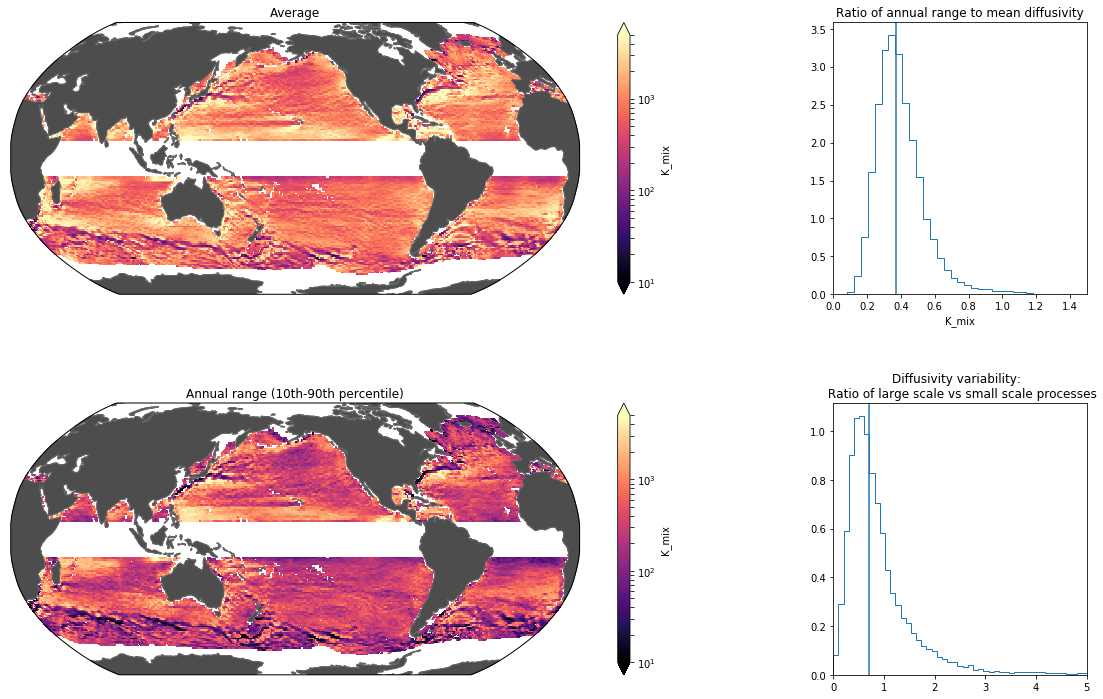

In [12]:
fig = plt.figure(figsize=[20,12])
gs = gridspec.GridSpec(2, 2,width_ratios=[3, 1])


ax1 = plt.subplot(gs[0], projection=proj)
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2], projection=proj)
ax4 = plt.subplot(gs[3])

# mean Kmix
Kmix_mean = Kmix['uncorrected']['K_mix'].mean('time')
Kmix_mean.plot(ax=ax1, norm=mpl.colors.SymLogNorm(10), **k_map_kwargs)
ax1.set_title('Average')

# annual range Kmix
Kmix_annual_range = annual_range(Kmix['uncorrected']['K_mix'], range_cut=annual_range_percentiles)
Kmix_annual_range.plot(ax=ax3, norm=mpl.colors.SymLogNorm(10), **k_map_kwargs)
ax3.set_title('Annual range (%ith-%ith percentile)' %tuple(annual_range_percentiles*100))

# histogram of annual range/ mean
mean_annual_ratio = Kmix_annual_range / Kmix_mean
mean_annual_ratio.plot.hist(bins=np.linspace(0,2,50), density=True, histtype='step', ax=ax2)
ax2.axvline(mean_annual_ratio.median())
ax2.set_xlim([0, 1.5])
ax2.set_title('Ratio of annual range to mean diffusivity')

ml_eke_ratio =  Kmix['uncorrected']['ml_variation'].std('time')/ Kmix['uncorrected']['eke_variation'].std('time')
ml_eke_ratio.plot.hist(bins=np.linspace(0,5,50), density=True, histtype='step', ax=ax4)
ax4.axvline(ml_eke_ratio.median())
ax4.set_xlim([0, 5])
ax4.set_title('Diffusivity variability:  \n Ratio of large scale vs small scale processes')

fig.subplots_adjust(hspace=0.4)
for ax in [ax1, ax3]:
    map_polish(ax)
    
fig.savefig('plots/Fig1.pdf')

# Figure 2 | Example Timeseries
The figures below are combined in Adobe Illustrator for the final result.

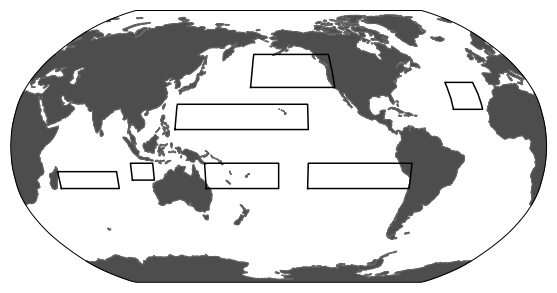

In [13]:
example_Boxes = dict(
    North_Eq_Pacific = dict(XC=slice(130, 220), YC=slice(10, 25)),
    South_Eq_Pacific = dict(XC=slice(150, 200), YC=slice(-25, -10)),
    South_Eq_Pacific_East = dict(XC=slice(220, 290), YC=slice(-25, -10)),
    ITF = dict(XC=slice(100, 115), YC=slice(-20, -10)),
    Southern_Indian = dict(XC=slice(50, 90), YC=slice(-25, -15)),
    Northern_Pacific = dict(XC=slice(180, 240), YC=slice(35, 55)),
    North_Atlantic = dict(XC=slice(320, 340), YC=slice(22, 38)),
)

example_indicies = dict(
    North_Eq_Pacific = [('NINO34', 1)],
    South_Eq_Pacific = [('NINO34', 1)],
    South_Eq_Pacific_East = [('NINO34', -1)],
    ITF = [('DMI', 1)],
    Southern_Indian = [('NINO34', -1)],
    Northern_Pacific = [('PDO', 1)],
    North_Atlantic = [('NAO', 1)],
)

# Empty map for schematic
fig, ax = plt.subplots(subplot_kw={'projection':proj}, figsize=[10,5])
for bb in example_Boxes.keys():
        box_plot_dict(example_Boxes[bb], xdim='XC', ydim='YC', ax=ax, color='k', transform=trans)
map_polish(ax)
ax.set_global()
fig.savefig('plots/blank_map.pdf')

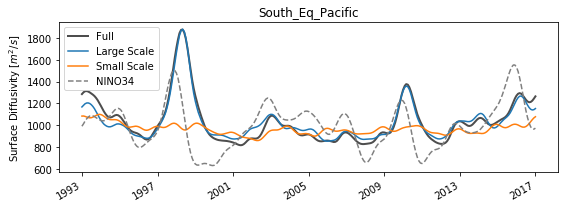

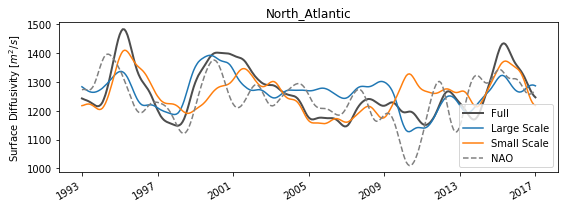

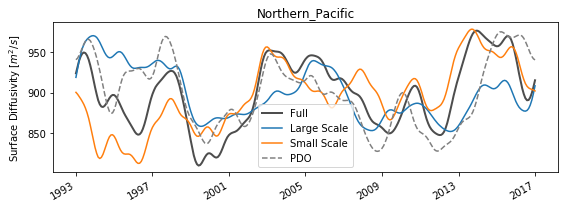

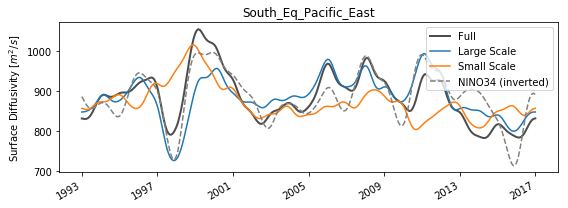

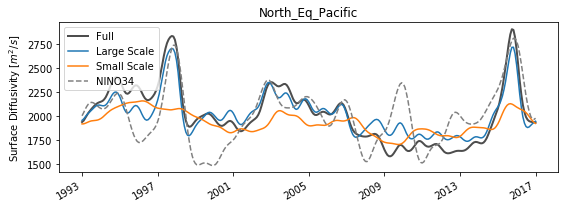

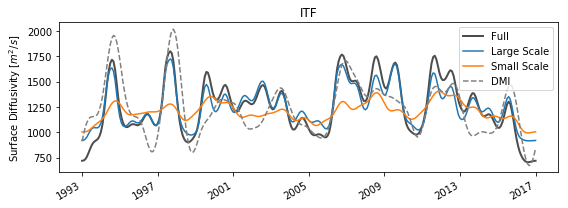

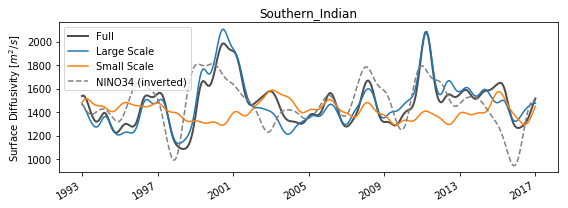

In [14]:
ds = Kmix['uncorrected']

# Load climate indicies
resamplt_spec = '1M'
ref_ds = ds

clim_indicies = xr.Dataset()

ENSO_raw = xr.open_dataset('data/ENSO.nc')
clim_indicies['NINO34'] = ENSO_raw.resample(time=resamplt_spec).mean().NINO34.interp_like(ref_ds)

PDO_raw = xr.open_dataset('data/PDO.nc')
clim_indicies['PDO'] = PDO_raw.resample(time=resamplt_spec).mean().PDO.interp_like(ref_ds)

NAO_raw = xr.open_dataset('data/NAO.nc')
clim_indicies['NAO'] = NAO_raw.resample(time=resamplt_spec).mean().NAO.interp_like(ref_ds)

DMI_raw = xr.open_dataset('data/DMI.nc').rename({'WEDCEN2':'time'})
clim_indicies['DMI'] = DMI_raw.resample(time=resamplt_spec).mean().DMI.interp_like(ref_ds)

for vv in clim_indicies.data_vars:
    # Filter with the same window as vel data
    clim_indicies[vv] = filter_1D(clim_indicies[vv], win)

for bb in example_Boxes.keys():
    fig, ax = plt.subplots(figsize=[8,3])

    kmix = weighted_mean(ds['K_mix'].sel(**example_Boxes[bb]), ds.rA, dim=['XC', 'YC'])
    kmix_ml = weighted_mean((ds['ml_variation'] + ds['mean_K_mix']).sel(**example_Boxes[bb]), ds.rA, dim=['XC', 'YC'])
    kmix_eke = weighted_mean((ds['eke_variation'] + ds['mean_K_mix']).sel(**example_Boxes[bb]), ds.rA, dim=['XC', 'YC'])
    
    g_ref = kmix
    
    kmix.plot(ax=ax, label='Full', linewidth=2, color='0.3')
    kmix_ml.plot(ax=ax , label='Large Scale')
    kmix_eke.plot(ax=ax, label='Small Scale')
    
    if bb in example_indicies.keys():
        for bi,ii in enumerate(example_indicies[bb]):
            if ii[1] == -1:
                label = '%s (inverted)'
            else:
                label = '%s'
            clim_index = xarray_norm(clim_indicies[ii[0]]*ii[1], g_ref)
            if ii[0] == 'NAO':
                clim_index = filter_1D(clim_index, 3)
            clim_index.plot(ax=ax, linestyle='--', color='0.5', label=label %ii[0])
    ax.set_ylabel('Surface Diffusivity [$m^2/s$]')
    ax.set_xlabel('')
    plt.legend()
    plt.title(bb)
    plt.tight_layout()
    fig.savefig('plots/timeseries_%s.pdf' %bb)

# Figure 3 | Longterm diffusivity trends

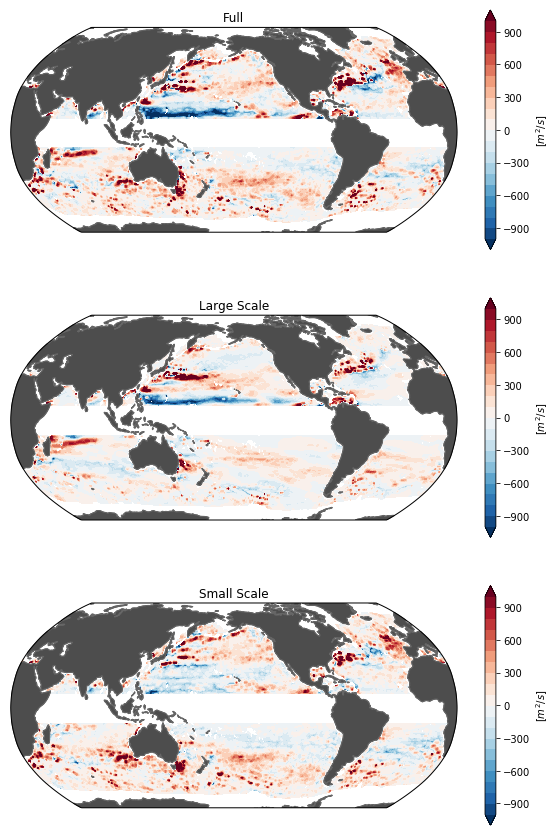

In [15]:
fig, axarr = plt.subplots(nrows=3, subplot_kw={'projection':proj}, figsize=[10,15])
ds = Kmix['uncorrected']

for name, ds, ax in zip(['Full', 'Large Scale', 'Small Scale'],
                    [ds['K_mix'], ds['ml_variation'], ds['eke_variation']],
                       axarr):
    trend = linear_trend(ds, 'time').sel(parameter='slope') * len(ds.time)

    trend.plot.contourf(levels=21, ax=ax, vmax=1e3, transform=trans, cbar_kwargs={'label':'[$m^2/s$]'})
    map_polish(ax)
    ax.set_title(name)
fig.savefig('plots/Fig3_trends.pdf')

# Figure 4 | KOC results

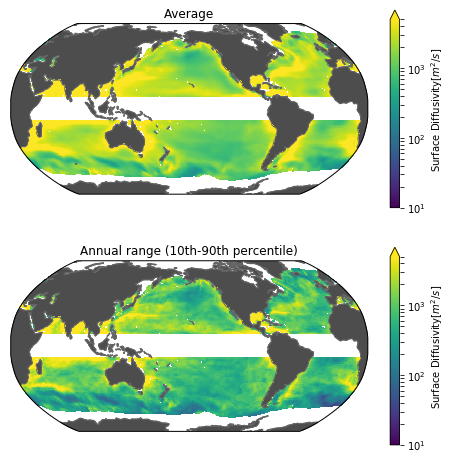

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[8,8], subplot_kw={'projection':proj})

# mean Kmix
Kmin_mean = Kmix['corrected']['K_min'].mean('time')
Kmin_mean.plot(ax=ax1, norm=mpl.colors.SymLogNorm(10), cmap='viridis', cbar_kwargs={'label': 'Surface Diffusivity[$m^2/s$]'}, **k_map_kwargs)
ax1.set_title('Average')
map_polish(ax1)

# annual range Kmix
Kmin_annual_range = annual_range(Kmix['corrected']['K_min'], range_cut=annual_range_percentiles)
Kmin_annual_range.plot(ax=ax2, norm=mpl.colors.SymLogNorm(10), cmap='viridis', cbar_kwargs={'label': 'Surface Diffusivity[$m^2/s$]'}, **k_map_kwargs)
ax2.set_title('Annual range (%ith-%ith percentile)' %tuple(annual_range_percentiles*100))
map_polish(ax2)

fig.savefig('plots/Fig4_koc_mean_range.png', dpi=300)

# Fig 5 KOC mechanisms

This figure shows the strong dependence of KOC on the mean flow in "Pacific Boxes"

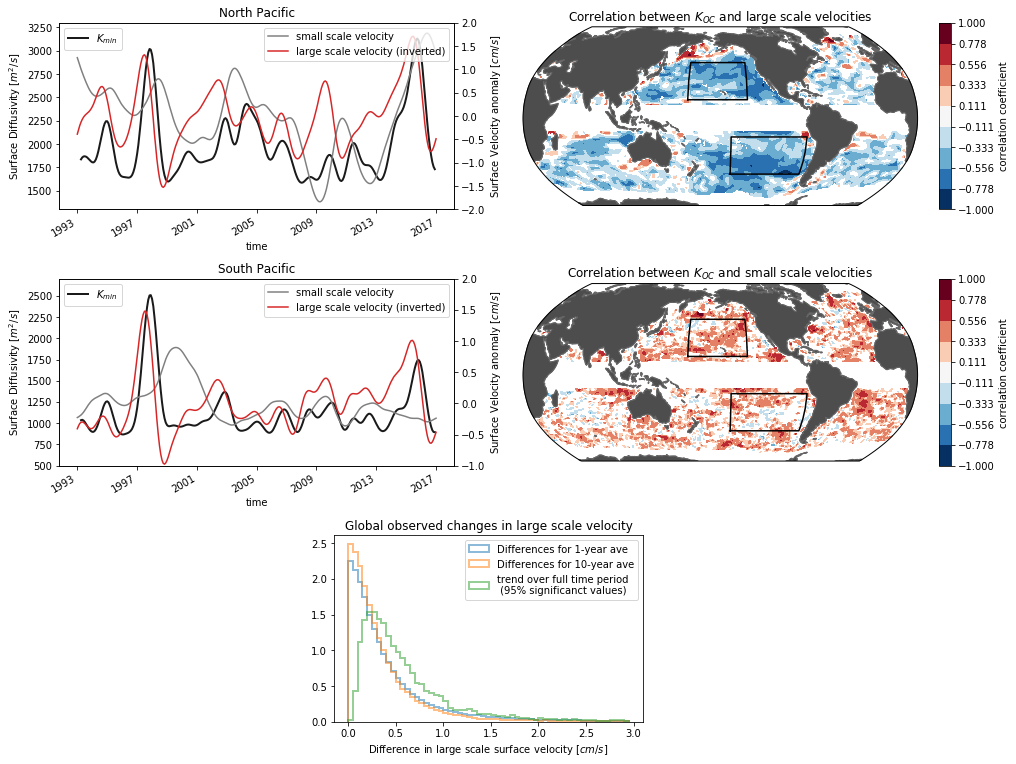

In [17]:
Boxes = {
    'North Pacific':{'XC':slice(170,225),'YC':slice(15,45)},
    'South Pacific':{'XC':slice(210,280),'YC':slice(-45,-15)},
         }

ubar_uncorrected = Kmix['uncorrected']['u_bar']

kmin = Kmix['corrected']['K_min']
urms = Kmix['corrected']['u_rms']
ubar = Kmix['corrected']['u_bar']

fig = plt.figure(constrained_layout=True, figsize=[14,10.5])
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], projection=proj)
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3], projection=proj)
ax5 = plt.subplot(gs[4:])


for (bi, bb), ax, ylim in zip(Boxes.items(), [ax1, ax3], [[-2, 2],[-1, 2]]):
    cut_box = kmin.sel(**bb)
    filter_1D(weighted_mean(cut_box, cut_box.rA, dim=['XC', 'YC']), win).plot(ax=ax, color='0.1', linewidth=2, label='$K_{min}$')
    
    # twin ax
    ax_secondary = ax.twinx()
    
    for ds, label, color in zip([urms, -ubar], ['small scale velocity', 'large scale velocity (inverted)'], ['0.5', 'C3']):
        cut_box = ds.sel(**bb)
        mean_box = weighted_mean(cut_box, cut_box.rA, dim=['XC', 'YC']) * 100 # in cm
        filter_1D(mean_box - mean_box.mean('time'), win).plot(ax=ax_secondary, color=color, label=label)
        
    ax.set_ylabel('Surface Diffusivity [$m^2/s$]')
    ax.legend(loc=2)
    ax.set_title(bi)
    ax_secondary.set_ylabel('Surface Velocity anomaly [$cm/s$]')
    ax_secondary.legend(loc=1)
    ax_secondary.set_ylim(ylim)

ax1.set_ylim([1300, 3300])
ax3.set_ylim(500, 2700)

# Show the correlation between ubar and kmin for filtered results
corr_u = xr_linregress(filter_1D(ubar, win).fillna(0), filter_1D(kmin, win).fillna(0))
corr_eke = xr_linregress(filter_1D(urms, win).fillna(0), filter_1D(kmin, win).fillna(0))

for corr, ax, title in zip([corr_u, corr_eke], [ax2, ax4], ['Correlation between $K_{OC}$ and large scale velocities',
                                                            'Correlation between $K_{OC}$ and small scale velocities']):
    corr.r_value.where(corr.p_value <= 0.01).plot.contourf(ax=ax, transform=trans, vmax=1,
                                                           levels=10, cbar_kwargs={'label':'correlation coefficient'})
    for bi, bb in Boxes.items():
        box_plot_dict(bb, xdim='XC', ydim='YC', ax=ax, color='k', transform=trans)
    ax.set_title(title)
    map_polish(ax)

# Compare the variability of surface velocities globally

ds = ubar_uncorrected * 100 # in cm/s
sig_level = 95
trend = linear_trend(ds.chunk({'time': -1}), 'time')
p = trend.sel(parameter='p_value')
trend = trend.sel(parameter='slope').where(p<=1-(sig_level/100)).load()
# trend over total time period
trend = (trend * len(ds.time))

kw = dict(
    bins = np.arange(0, 3, 0.05),
    density=True,
    alpha=0.5,
    cumulative=False,
    histtype='step',
    linewidth=2,
    ax=ax5,
)

# Plot a histogram of 1/5/10 yr diffs of u, as well as a histogram of longterm trends.
for ya in [1, 10]:
    ave_time = '%iA' %ya
    u_diff = ds.resample(time=ave_time).mean('time').diff('time')
    abs(u_diff).plot.hist(label= 'Differences for %i-year ave' %ya, **kw)
abs(trend).plot.hist(label='trend over full time period \n (%i%s significanct values)' % (sig_level, '%'),**kw)
ax5.legend()
ax5.set_title('Global observed changes in large scale velocity')
ax5.set_xlabel('Difference in large scale surface velocity [$cm/s$]')
ax5.set_aspect(0.75)
fig.savefig('plots/Fig5_koc_vel.pdf')

# Figure 6 | Relationship for KOC and Kmix for the corrected velocities.

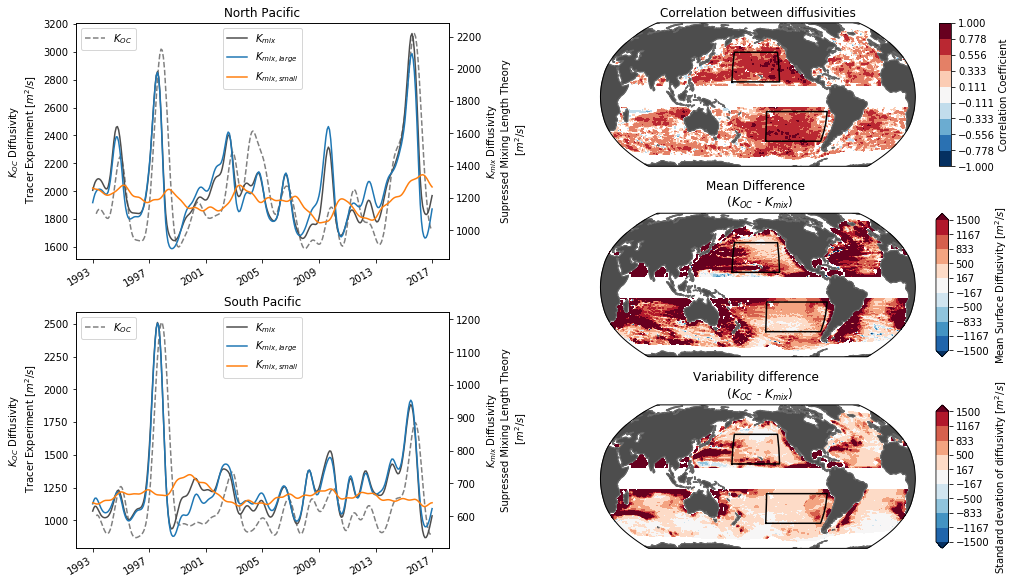

In [18]:
ds = Kmix['corrected']

def timeseries(da, box_dict):
    cut_box = da.sel(**box_dict)
    return weighted_mean(cut_box, cut_box.rA, dim=['XC', 'YC'])


fig = plt.figure(constrained_layout=True, figsize=[14,8])
gs = gridspec.GridSpec(6, 2, figure=fig, wspace=0.3, hspace=0.4)
ax1 = plt.subplot(gs[0:3, 0])
ax2 = plt.subplot(gs[3:, 0])
ax3 = plt.subplot(gs[0:2, 1], projection=proj)
ax4 = plt.subplot(gs[2:4, 1], projection=proj)
ax5 = plt.subplot(gs[4:, 1], projection=proj)

for (bi, bb), ax in zip(Boxes.items(), [ax1, ax2]):

    for var in ['K_min']:
        filter_1D(timeseries(ds[var], bb), win).plot(ax=ax, color='0.5', linestyle='--', label='$K_{OC}$')
    
    ax_secondary = ax.twinx()
#     ax.autoscale('tight')
    for plot_ds, color, label in zip([ds['K_mix'],
                               ds['ml_variation'] + ds['mean_K_mix'], 
                               ds['eke_variation'] + ds['mean_K_mix']],
                               ['0.3', 'C0', 'C1'],
                               ['$K_{mix}$', '$K_{mix, large}$', '$K_{mix, small}$']):
        timeseries(plot_ds, bb).plot(ax=ax_secondary, color=color, label=label)
    ax.set_title(bi)
    ax.set_ylabel('$K_{OC}$ Diffusivity \n Tracer Experiment [$m^2/s$]')
    ax.legend(loc=2)
    ax.set_xlabel('')
    ax_secondary.legend(loc=9)
    ax_secondary.set_ylabel('$K_{mix}$ Diffusivity \n Supressed Mixing Length Theory \n [$m^2/s$]')

# maps
corr = xr_linregress(filter_1D(ds['K_mix'], win).fillna(0), filter_1D(ds['K_min'], win).fillna(0))
corr_map = corr.r_value.where(corr.p_value <= 0.01)

offset = ds['K_min'].mean('time') - ds['K_mix'].mean('time')
var_diff = ds['K_min'].std('time') - ds['K_mix'].std('time') 
for ds, ax, title, clabel, vmax in zip(
    [corr_map, offset, var_diff],
    [ax3, ax4, ax5],
    ['Correlation between diffusivities', 'Mean Difference \n ($K_{OC}$ - $K_{mix}$)', 'Variability difference \n ($K_{OC}$ - $K_{mix}$)'],
    ['Correlation Coefficient', 'Mean Surface Diffusivity [$m^2/s$]', 'Standard devation of diffusivity [$m^2/s$]'],
    [1, 1500, 1500]):
    ds.plot.contourf(ax=ax, vmax=vmax, transform=trans, levels=10, cbar_kwargs={'label':clabel})
    for bi, bb in Boxes.items():
        box_plot_dict(bb, xdim='XC', ydim='YC', ax=ax, color='k', transform=trans)
    ax.set_title(title)
    map_polish(ax)
fig.savefig('plots/Fig6_koc_kmix.pdf')